# Scilla: Oscilloscope Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math

In [2]:
# Model parameters
Model_Fsampl = 1e3
Model_Tsampl = 1 / Model_Fsampl
Model_StartTime = 0
Model_EndTime = 1
Model_N = Model_EndTime / Model_Tsampl
Model_TimeVector = np.linspace(Model_StartTime, Model_EndTime, int(Model_N))

## ADC

The main task of ADC is to convert continious signal to discrete. We can model continious signal as some function, for example $ f(t) = sin(\Omega_{0} t) $, where $ \Omega_{0} = 2\pi f $

Text(0.5, 0, 't, s')

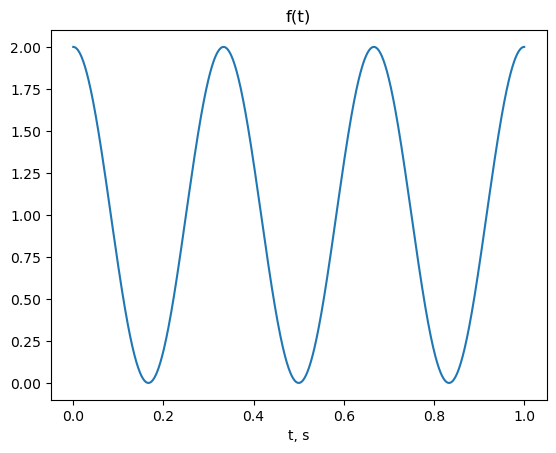

In [3]:
# f(t) parameters
Input_F = 3
Input_T = 1 / Input_F
Input_A = 1
Input_Phase = 0
Input_OmegaZero = 2 * np.pi * Input_F
Input_FunctionValues = 1 + Input_A * np.cos(Input_OmegaZero * Model_TimeVector)

plt.plot(Model_TimeVector, Input_FunctionValues)
plt.title("f(t)")
plt.xlabel("t, s")

### Sampler

To sample signal we need to apply a "switch" that opens every $ T_{s} $ seconds. This "switch" is a sampling function:

$$ S(t) = \sum_{n = 0}^{\infty} \delta(t - nT_{s}) $$.

To sample input signal we need to modulate input signal $ f(t) $ by sampling function $ S(t) $.

$$ o(t) = f(t) S(t) $$

We can also represent sampled signal as discrete sequence $ f[n] = \{ f_{0}, f_{1}, f_{2}, ... \} $

Text(0.5, 0, 't, s')

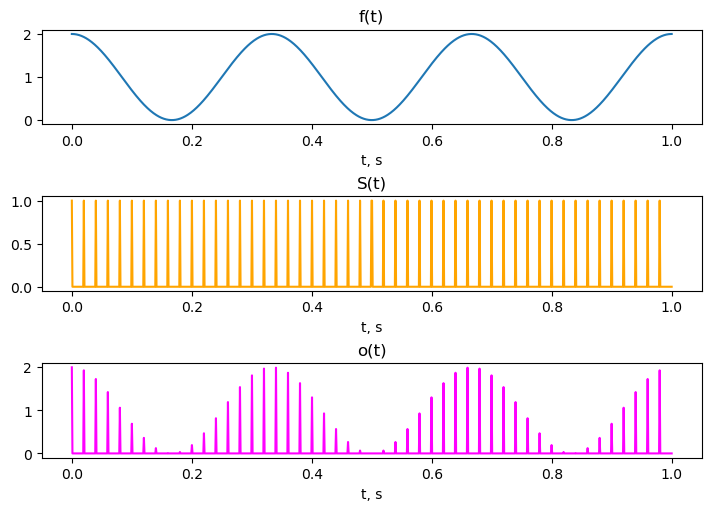

In [4]:
# S(t) parameters
Sampling_F = 50
Sampling_T = 1 / Sampling_F
Sampling_N = int(Model_EndTime / Sampling_T)

def delta_function(t):
    if np.isclose(t, 0.0, atol=0.00051): # TODO: Change atol!
        return 1
    return 0

def sampling_function(t, N, Ts):
    value = 0
    for n in range(0, N):
        value += delta_function(t - n * Ts)
    return value

Sampling_FunctionValues = np.arange(len(Model_TimeVector), dtype=int)
for n, t in enumerate(Model_TimeVector):
    Sampling_FunctionValues[n] = sampling_function(t, Sampling_N, Sampling_T)

# o(t) parameters
Sampler_FunctionValues = Input_FunctionValues * Sampling_FunctionValues

figure, axis = plt.subplots(3, 1, layout="constrained", figsize=(7, 5))

axis[0].plot(Model_TimeVector, Input_FunctionValues)
axis[0].set_title("f(t)")
axis[0].set_xlabel("t, s")

axis[1].plot(Model_TimeVector, Sampling_FunctionValues, color="orange")
axis[1].set_title("S(t)")
axis[1].set_xlabel("t, s")

axis[2].plot(Model_TimeVector, Sampler_FunctionValues, color="magenta")
axis[2].set_title("o(t)")
axis[2].set_xlabel("t, s")


### Quantization

Text(0.5, 1.0, 'After quantization')

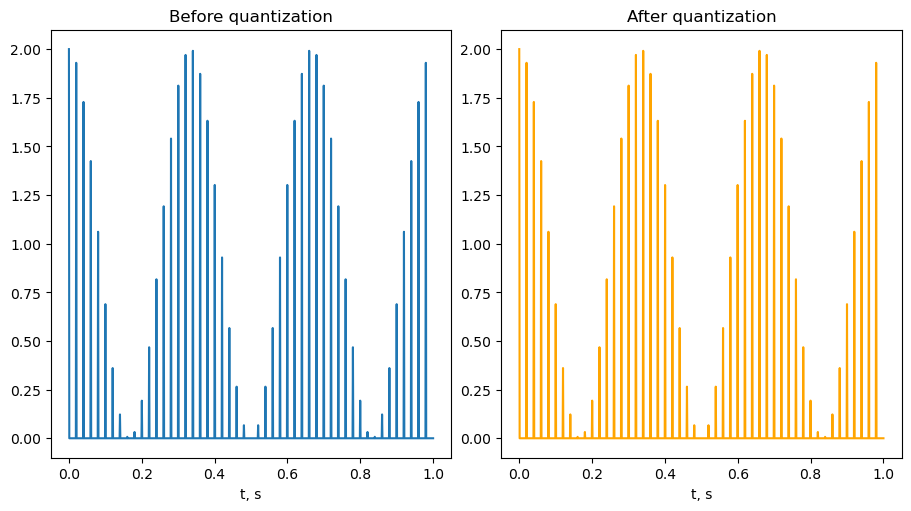

In [7]:
Quantization_Bitdepth = 12
Quantization_MinValue = 0.0
Quantization_MaxValue = 2.0
Quantization_Range = abs(Quantization_MinValue) + abs(Quantization_MaxValue)
Quantization_MaxLsbValue = int(math.pow(2, Quantization_Bitdepth))
Quantization_Step = Quantization_Range / Quantization_MaxLsbValue

Quantization_ValuesTable = np.linspace(Quantization_MinValue, Quantization_MaxValue, Quantization_MaxLsbValue)

def find_nearest(value, table):
    min_diff_value = 99999999
    min_diff_index = 99999999

    for index, table_value in enumerate(table):
        diff = abs(table_value - value)
        if diff < min_diff_value:
            min_diff_value = diff
            min_diff_index = index

    return table[min_diff_index]

Quantization_FunctionValues = []
for sampler_value in Sampler_FunctionValues:
    if sampler_value == 0.0:
        Quantization_FunctionValues.append(0.0)
    else:
        Quantization_FunctionValues.append(find_nearest(sampler_value, Quantization_ValuesTable))

figure, axis = plt.subplots(1, 2, layout="constrained", figsize=(9,5))

axis[0].plot(Model_TimeVector, Sampler_FunctionValues)
axis[0].set_xlabel("t, s")
axis[0].set_title("Before quantization")

axis[1].plot(Model_TimeVector, Quantization_FunctionValues, color="orange")
axis[1].set_xlabel("t, s")
axis[1].set_title("After quantization")


Text(0.5, 0, 'n')

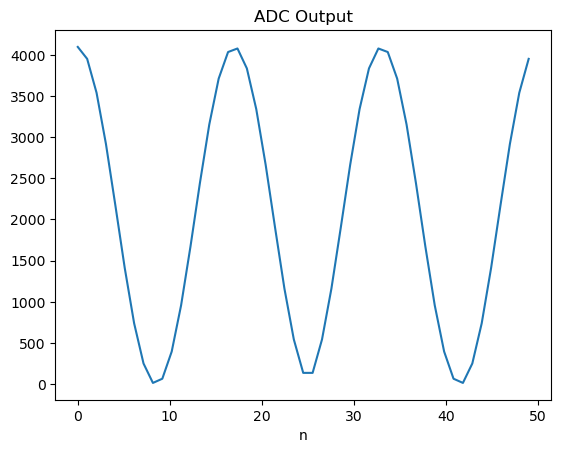

In [6]:
ADC_Output = list(filter(lambda x: x != 0.0, Quantization_FunctionValues))
ADC_Output = list(map(lambda x: int(x / Quantization_Step), ADC_Output))

plt.plot(np.linspace(0, len(ADC_Output), len(ADC_Output)), ADC_Output)
plt.title("ADC Output")
plt.xlabel("n")